In [1]:
!pip install transformers

In [2]:
import pandas as pd
import torch
from torch.nn import CrossEntropyLoss
from torch.optim import Adam
from transformers import BertTokenizer, BertForSequenceClassification, BertConfig
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from tqdm import tqdm

In [3]:
# 데이터 불러오기
df_train = pd.read_csv('complete_train.csv')
df_test = pd.read_csv('complete_test.csv')

In [4]:
df_train['text'] = df_train['title'] + ' ' + df_train['content']
df_test['text'] = df_test['title'] + ' ' + df_test['content']

# NaN 값을 포함하는 행 삭제
df_train.dropna(subset=['text'], inplace=True)

In [5]:
# 원본 데이터를 학습 데이터와 테스트 데이터로 나눔
train_df, val_df = train_test_split(df_train, test_size=500, random_state=42)

In [6]:
# KoBERT 토크나이저 로드
tokenizer = BertTokenizer.from_pretrained('monologg/kobert')

In [7]:
def encode_data(texts, tokenizer, max_len=512):
    all_tokens = []
    all_masks = []

    for text in texts:
        encoded_dict = tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=max_len,
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        # 직접 패딩 수행
        padding_length = max_len - len(encoded_dict['input_ids'][0])
        all_tokens.append(torch.cat([encoded_dict['input_ids'], torch.zeros((1, padding_length), dtype=torch.long)], dim=1))
        all_masks.append(torch.cat([encoded_dict['attention_mask'], torch.zeros((1, padding_length), dtype=torch.long)], dim=1))

    all_tokens = torch.cat(all_tokens, dim=0)
    all_masks = torch.cat(all_masks, dim=0)

    return all_tokens, all_masks

In [8]:
# 학습 데이터 인코딩
train_input_ids, train_attention_masks = encode_data(train_df['text'], tokenizer)
train_labels2 = torch.tensor(train_df['label2'].values)

# 테스트 데이터 인코딩 및 성능 평가
val_input_ids, val_attention_masks = encode_data(val_df['text'], tokenizer)
val_labels2 = torch.tensor(val_df['label2'].values)

In [9]:
# 데이터셋 및 데이터 로더 생성
train_dataset = TensorDataset(train_input_ids, train_attention_masks, train_labels2)
train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True)

val_dataset = TensorDataset(val_input_ids, val_attention_masks, val_labels2)
val_dataloader = DataLoader(val_dataset, batch_size=2, shuffle=False)

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# 모델 정의
class KoBERTForSingleLabelClassification(torch.nn.Module):
    def __init__(self, num_labels):
        super(KoBERTForSingleLabelClassification, self).__init__()
        self.config = BertConfig.from_pretrained('monologg/kobert', num_labels=num_labels, output_hidden_states=True)
        self.bert = BertForSequenceClassification.from_pretrained('monologg/kobert', config=self.config)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids, attention_mask=attention_mask)
        return outputs.logits


model = KoBERTForSingleLabelClassification(train_df['label2'].nunique()).to(device)
optimizer = Adam(model.parameters(), lr=1e-5)
loss_fn = torch.nn.CrossEntropyLoss()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at monologg/kobert and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [11]:
from sklearn.metrics import f1_score

EPOCHS = 20
train_losses = []
val_losses = []
val_accuracies = []
val_f1_scores = []
best_accuracy = 0
best_model_path = "best_model_label2.pth"

for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    total_correct = 0
    total_samples = 0

    for batch in tqdm(train_dataloader, desc=f"Training Epoch {epoch+1}/{EPOCHS}"):
        optimizer.zero_grad()
        input_ids, attention_mask, label = [b.to(device) for b in batch]
        logits = model(input_ids, attention_mask=attention_mask)

        loss = loss_fn(logits, label)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_correct += (logits.argmax(dim=1) == label).sum().item()
        total_samples += label.size(0)

    avg_train_loss = total_loss / total_samples
    train_losses.append(avg_train_loss)

    # Evaluate on validation set
    model.eval()
    val_loss = 0
    val_correct = 0
    val_samples = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in val_dataloader:
            input_ids, attention_mask, label = [b.to(device) for b in batch]
            logits = model(input_ids, attention_mask=attention_mask)

            loss = loss_fn(logits, label)
            val_loss += loss.item()

            preds = logits.argmax(dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(label.cpu().numpy())

            val_correct += (preds == label).sum().item()
            val_samples += label.size(0)

    avg_val_loss = val_loss / val_samples
    val_losses.append(avg_val_loss)
    val_accuracy = val_correct / val_samples
    val_accuracies.append(val_accuracy)

    current_f1 = f1_score(all_labels, all_preds, average='macro')
    val_f1_scores.append(current_f1)

    # 최고 정확도를 갱신할 경우 모델 저장
    if val_accuracy > best_accuracy:
        best_accuracy = val_accuracy
        torch.save(model.state_dict(), best_model_path)
        print(f"Model saved for epoch {epoch+1} with accuracy: {best_accuracy:.4f}")

    # 출력 코드 추가
    print(f"Epoch {epoch+1}/{EPOCHS}")
    print(f"Train Loss: {avg_train_loss:.4f}")
    print(f"Validation Loss: {avg_val_loss:.4f}")
    print(f"Validation Accuracy1: {val_accuracy:.4f}")
    print(f"Validation F1 Score for Label1: {current_f1:.4f}")
    print("===================================")


Training Epoch 1/20: 100%|██████████| 1000/1000 [01:41<00:00,  9.90it/s]


Model saved for epoch 1 with accuracy: 0.4520
Epoch 1/20
Train Loss: 0.3907
Validation Loss: 0.7422
Validation Accuracy1: 0.4520
Validation F1 Score for Label1: 0.1717


Training Epoch 2/20: 100%|██████████| 1000/1000 [01:40<00:00,  9.93it/s]


Model saved for epoch 2 with accuracy: 0.4700
Epoch 2/20
Train Loss: 0.3445
Validation Loss: 0.6771
Validation Accuracy1: 0.4700
Validation F1 Score for Label1: 0.2447


Training Epoch 3/20: 100%|██████████| 1000/1000 [01:40<00:00,  9.98it/s]


Model saved for epoch 3 with accuracy: 0.4840
Epoch 3/20
Train Loss: 0.3182
Validation Loss: 0.6589
Validation Accuracy1: 0.4840
Validation F1 Score for Label1: 0.2860


Training Epoch 4/20: 100%|██████████| 1000/1000 [01:40<00:00, 10.00it/s]


Model saved for epoch 4 with accuracy: 0.5200
Epoch 4/20
Train Loss: 0.2940
Validation Loss: 0.6155
Validation Accuracy1: 0.5200
Validation F1 Score for Label1: 0.3898


Training Epoch 5/20: 100%|██████████| 1000/1000 [01:39<00:00, 10.03it/s]


Model saved for epoch 5 with accuracy: 0.5440
Epoch 5/20
Train Loss: 0.2673
Validation Loss: 0.6192
Validation Accuracy1: 0.5440
Validation F1 Score for Label1: 0.4185


Training Epoch 6/20: 100%|██████████| 1000/1000 [01:40<00:00,  9.98it/s]


Model saved for epoch 6 with accuracy: 0.5620
Epoch 6/20
Train Loss: 0.2413
Validation Loss: 0.6119
Validation Accuracy1: 0.5620
Validation F1 Score for Label1: 0.4507


Training Epoch 7/20: 100%|██████████| 1000/1000 [01:40<00:00,  9.97it/s]


Epoch 7/20
Train Loss: 0.2111
Validation Loss: 0.6443
Validation Accuracy1: 0.5360
Validation F1 Score for Label1: 0.4144


Training Epoch 8/20: 100%|██████████| 1000/1000 [01:40<00:00,  9.97it/s]


Epoch 8/20
Train Loss: 0.1740
Validation Loss: 0.6795
Validation Accuracy1: 0.5000
Validation F1 Score for Label1: 0.4037


Training Epoch 9/20: 100%|██████████| 1000/1000 [01:39<00:00, 10.04it/s]


Epoch 9/20
Train Loss: 0.1413
Validation Loss: 0.7849
Validation Accuracy1: 0.4960
Validation F1 Score for Label1: 0.4073


Training Epoch 10/20: 100%|██████████| 1000/1000 [01:40<00:00,  9.94it/s]


Epoch 10/20
Train Loss: 0.1142
Validation Loss: 0.7939
Validation Accuracy1: 0.5400
Validation F1 Score for Label1: 0.4496


Training Epoch 11/20: 100%|██████████| 1000/1000 [01:40<00:00, 10.00it/s]


Epoch 11/20
Train Loss: 0.0906
Validation Loss: 0.8833
Validation Accuracy1: 0.4980
Validation F1 Score for Label1: 0.4180


Training Epoch 12/20: 100%|██████████| 1000/1000 [01:40<00:00,  9.94it/s]


Epoch 12/20
Train Loss: 0.0692
Validation Loss: 0.9566
Validation Accuracy1: 0.5120
Validation F1 Score for Label1: 0.4392


Training Epoch 13/20: 100%|██████████| 1000/1000 [01:40<00:00,  9.99it/s]


Epoch 13/20
Train Loss: 0.0536
Validation Loss: 0.9937
Validation Accuracy1: 0.5080
Validation F1 Score for Label1: 0.4172


Training Epoch 14/20: 100%|██████████| 1000/1000 [01:40<00:00,  9.95it/s]


Epoch 14/20
Train Loss: 0.0497
Validation Loss: 1.0532
Validation Accuracy1: 0.4920
Validation F1 Score for Label1: 0.4134


Training Epoch 15/20: 100%|██████████| 1000/1000 [01:39<00:00, 10.02it/s]


Epoch 15/20
Train Loss: 0.0400
Validation Loss: 1.0381
Validation Accuracy1: 0.5220
Validation F1 Score for Label1: 0.4491


Training Epoch 16/20: 100%|██████████| 1000/1000 [01:39<00:00, 10.02it/s]


Epoch 16/20
Train Loss: 0.0366
Validation Loss: 1.1416
Validation Accuracy1: 0.5020
Validation F1 Score for Label1: 0.4102


Training Epoch 17/20: 100%|██████████| 1000/1000 [01:40<00:00,  9.98it/s]


Epoch 17/20
Train Loss: 0.0314
Validation Loss: 1.2289
Validation Accuracy1: 0.5020
Validation F1 Score for Label1: 0.3822


Training Epoch 18/20: 100%|██████████| 1000/1000 [01:40<00:00,  9.98it/s]


Epoch 18/20
Train Loss: 0.0271
Validation Loss: 1.2589
Validation Accuracy1: 0.5140
Validation F1 Score for Label1: 0.4540


Training Epoch 19/20: 100%|██████████| 1000/1000 [01:39<00:00, 10.02it/s]


Epoch 19/20
Train Loss: 0.0251
Validation Loss: 1.2774
Validation Accuracy1: 0.5220
Validation F1 Score for Label1: 0.4478


Training Epoch 20/20: 100%|██████████| 1000/1000 [01:39<00:00, 10.07it/s]


Epoch 20/20
Train Loss: 0.0261
Validation Loss: 1.2543
Validation Accuracy1: 0.4940
Validation F1 Score for Label1: 0.3966


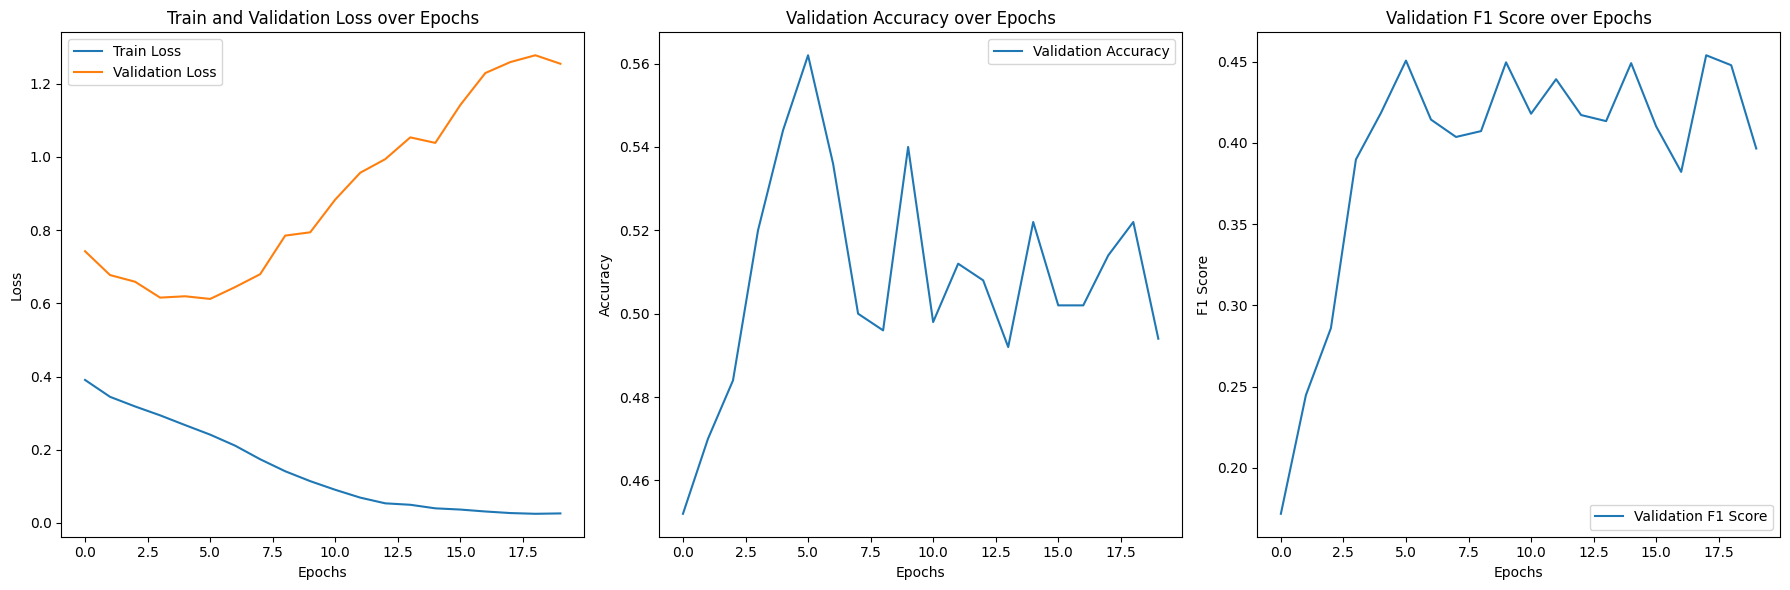

In [12]:
import matplotlib.pyplot as plt

# Plotting Train and Validation Loss, Accuracy and F1 Score
plt.figure(figsize=(18, 6))

# Train and Validation Loss
plt.subplot(1, 3, 1)
plt.plot(range(EPOCHS), train_losses, label="Train Loss")
plt.plot(range(EPOCHS), val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Train and Validation Loss over Epochs")
plt.legend()

# Validation Accuracy
plt.subplot(1, 3, 2)
plt.plot(range(EPOCHS), val_accuracies, label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Validation Accuracy over Epochs")
plt.legend()

# Validation F1 Score
plt.subplot(1, 3, 3)
plt.plot(range(EPOCHS), val_f1_scores, label="Validation F1 Score")
plt.xlabel("Epochs")
plt.ylabel("F1 Score")
plt.title("Validation F1 Score over Epochs")
plt.legend()

plt.tight_layout()
plt.show()

In [13]:
# 학습 데이터 인코딩
test_input_ids, test_attention_masks = encode_data(df_test['text'], tokenizer)
test_labels2 = torch.tensor(df_test['label2'].values)

test_dataset = TensorDataset(test_input_ids, test_attention_masks, test_labels2)
test_dataloader = DataLoader(test_dataset, batch_size=2, shuffle=False)


In [14]:
# 학습이 끝난 후 가장 좋은 성능을 보인 모델을 불러옵니다.
model.load_state_dict(torch.load(best_model_path))
model.eval()

# 테스트 데이터셋에 대한 예측을 수행
true_labels2 = []
predicted_labels2 = []
top2_preds2 = []

with torch.no_grad():
    for batch in test_dataloader:
        input_ids, attention_mask, label2 = [b.to(device) for b in batch]
        logits2 = model(input_ids, attention_mask=attention_mask)

        true_labels2.extend(label2.tolist())
        predicted_labels2.extend(logits2.argmax(dim=1).tolist())

        # Top-2 predictions for Label2
        _, top2_indices = torch.topk(logits2, 2, dim=1)
        top2_preds2.extend(top2_indices.tolist())

# Top-2 Accuracy 계산 for Label2
top2_accuracy2 = sum([1 for true, preds in zip(true_labels2, top2_preds2) if true in preds]) / len(true_labels2)

# f1-score를 포함한 성능 지표를 출력 for Label2
accuracy2 = sum([1 if true == pred else 0 for true, pred in zip(true_labels2, predicted_labels2)]) / len(true_labels2)
f1_2 = f1_score(true_labels2, predicted_labels2, average='weighted')

print(f"Test Accuracy for Label2: {accuracy2:.4f}")
print(f"Top-2 Accuracy for Label2: {top2_accuracy2:.4f}")
print(f"F1 Score for Label2: {f1_2:.4f}")


Test Accuracy for Label2: 0.5260
Top-2 Accuracy for Label2: 0.7240
F1 Score for Label2: 0.5057


In [15]:
print("\nTrue vs Predicted Labels:")
for true2, pred2 in zip(true_labels2, predicted_labels2):
    print(f"Label2 - True: {true2}, Predicted: {pred2}")


True vs Predicted Labels:
Label2 - True: 1, Predicted: 1
Label2 - True: 0, Predicted: 0
Label2 - True: 1, Predicted: 1
Label2 - True: 1, Predicted: 1
Label2 - True: 1, Predicted: 1
Label2 - True: 1, Predicted: 2
Label2 - True: 1, Predicted: 0
Label2 - True: 2, Predicted: 0
Label2 - True: 1, Predicted: 2
Label2 - True: 0, Predicted: 1
Label2 - True: 1, Predicted: 2
Label2 - True: 1, Predicted: 5
Label2 - True: 1, Predicted: 0
Label2 - True: 1, Predicted: 0
Label2 - True: 1, Predicted: 0
Label2 - True: 1, Predicted: 0
Label2 - True: 1, Predicted: 1
Label2 - True: 1, Predicted: 1
Label2 - True: 0, Predicted: 0
Label2 - True: 2, Predicted: 0
Label2 - True: 1, Predicted: 1
Label2 - True: 2, Predicted: 0
Label2 - True: 1, Predicted: 1
Label2 - True: 2, Predicted: 0
Label2 - True: 1, Predicted: 1
Label2 - True: 0, Predicted: 0
Label2 - True: 2, Predicted: 2
Label2 - True: 0, Predicted: 0
Label2 - True: 0, Predicted: 2
Label2 - True: 0, Predicted: 0
Label2 - True: 1, Predicted: 0
Label2 - Tru